# K-Nearest Neighbors (KNN) — Creditworthiness (Post-Preprocessing)

This notebook trains and evaluates a **KNN** classifier to predict `loan_status` using **scaled** preprocessed data.
Includes cross-validation to select the best number of neighbors (*k*), plus ROC/AUC and business interpretation.


## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, ConfusionMatrixDisplay, classification_report,
                             roc_curve, roc_auc_score)

## Load Preprocessed Data (Scaled)

In [3]:
train_scaled = pd.read_csv('train_scaled.csv')
test_scaled = pd.read_csv('test_scaled.csv')

X_train = train_scaled.drop('loan_status', axis=1)
y_train = train_scaled['loan_status']
X_test = test_scaled.drop('loan_status', axis=1)
y_test = test_scaled['loan_status']

print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

Train shape: (3660, 7) Test shape: (1569, 7)


## Cross-Validation to Select k (Precision as metric)

In [5]:
neighbors = list(range(1, 25))
cv_precision_scores = []

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='precision')
    cv_precision_scores.append(scores.mean())

cv_table = pd.DataFrame({'k': neighbors, 'Mean Precision': cv_precision_scores}).sort_values('Mean Precision', ascending=False).reset_index(drop=True)
display(cv_table.head(10))

optimal_k = neighbors[cv_precision_scores.index(max(cv_precision_scores))]
print(f'Optimal k (by mean CV precision): {optimal_k}')

,k,Mean Precision
0,9,0.807720
1,22,0.807471
2,21,0.807471
3,23,0.807471
4,13,0.807432
5,11,0.807384
6,24,0.807335
7,14,0.807297
8,20,0.807181
9,19,0.807181


Optimal k (by mean CV precision): 9


## Train Final KNN and Evaluate (Threshold = 0.5)

In [7]:
knn_final = KNeighborsClassifier(n_neighbors=optimal_k)
knn_final.fit(X_train, y_train)

y_prob = knn_final.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {acc:.3f}\nPrecision: {prec:.3f}\nRecall: {rec:.3f}\nF1 Score: {f1:.3f}")

Accuracy: 0.920
Precision: 0.797
Recall: 0.985
F1 Score: 0.881


## Confusion Matrix & Classification Report

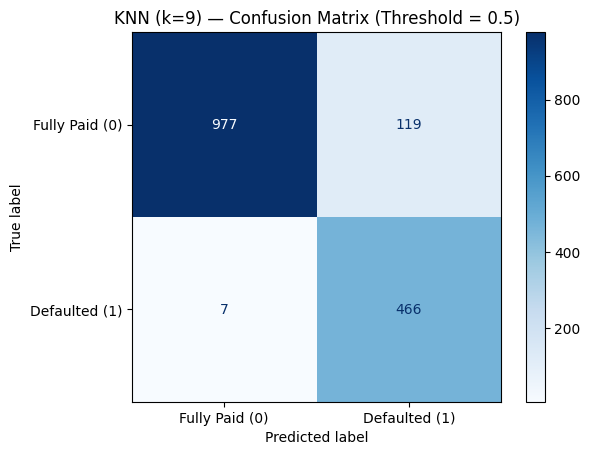

Classification Report:
                precision    recall  f1-score   support

Fully Paid (0)       0.99      0.89      0.94      1096
 Defaulted (1)       0.80      0.99      0.88       473

      accuracy                           0.92      1569
     macro avg       0.89      0.94      0.91      1569
  weighted avg       0.93      0.92      0.92      1569



In [9]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fully Paid (0)', 'Defaulted (1)']).plot(cmap='Blues')
plt.title(f'KNN (k={optimal_k}) — Confusion Matrix (Threshold = 0.5)')
plt.show()

print('Classification Report:')
print(classification_report(y_test, y_pred, target_names=['Fully Paid (0)', 'Defaulted (1)']))

## ROC Curve & AUC

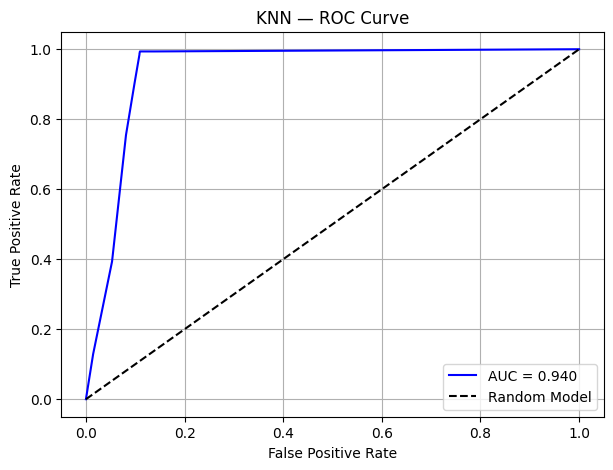

AUC Score: 0.940


In [11]:
fpr, tpr, thr = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}', color='blue')
plt.plot([0,1],[0,1],'k--', label='Random Model')
plt.title('KNN — ROC Curve')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.legend(); plt.grid(True); plt.show()

print(f'AUC Score: {auc:.3f}')

## Business Interpretation

- **CV to select k** ensures generalizable performance; evaluate with precision if the cost of a missed default is high.
- **Threshold control** can reduce false alarms or missed defaulters based on risk appetite.
- **Operations:** direct borderline scores to manual review; log reasons using nearest-neighbor examples for analyst context.


## Model Comparison Summary (How to Use)
Compare KNN metrics (Accuracy, Precision, Recall, F1, AUC) with Logistic, Decision Tree, and ANN.
If **precision** at your operating threshold is crucial, KNN may be competitive; otherwise consider ANN if it achieves higher AUC.
